In [1]:
import os
import subprocess
import xugrid as xu
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import animation
from mpl_toolkits.basemap import Basemap
import contextily as cx  
import ERA_5_analysis_support as era5
import xarray as xr
#import 
%matplotlib inline

### Hurrywave

In [2]:
base_path = r'C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest'

model_name = 'Sinterklaas_NorthSea' 
data_name = 'Sinterklaas_NorthSea'

model_path = os.path.join(base_path, '04_modelruns',model_name)

data_path = os.path.join(base_path, '01_data')

# ERA 5 data path
era_5_file = os.path.join(data_path,'ERA_5_data', data_name,f'{data_name}_era5_data.nc')

# Buoy data path
# buoy_data_path = os.path.join(data_path, 'buoy_data', 'buoy_data_2020_2024.nc')

# Buoy data path
buoy_data_path = os.path.join(data_path, 'Waterinfo_RWS', data_name)  # CHANGE THIS!!
print(model_path)

C:\Users\User\OneDrive\Documents\Python\PYTHON_MSC_CE\Year_2\Python_Thesis\cht_hurrywave\examples\DanielTest\04_modelruns\Sinterklaas_NorthSea


### Get station names

In [3]:
def read_station_names_from_obs(file_path):
    names = []
    with open(file_path, 'r') as f:
        for line in f:
            if '#' in line:
                name = line.split('# ')[1].strip()
                names.append(name)
    return names

obs_file_path = os.path.join(model_path, 'hurrywave.obs')
station_names = read_station_names_from_obs(obs_file_path)



# Extract Hurrywave results

In [4]:
### Post-process Hurrywave results
# Get the results from the netcdf file

nc_file = os.path.join(model_path,'hurrywave_map.nc')
his_file = os.path.join(model_path,'hurrywave_his.nc')

output_dir = os.path.join(model_path, '1_postprocessing')
if not os.path.exists(output_dir):
    os.makedirs(output_dir, exist_ok=True)

xu_nc = xu.open_dataset(nc_file , decode_times=True)

modig = {"msk": xu_nc["msk"],
         "zb": xu_nc["zb"],
         "Hm0": xu_nc["hm0"],
         #"Hm0_max": xu_nc["hm0max"],
         "Tp": xu_nc["tp"],
         "DIR": xu_nc["wavdir"],
         "ds": xu_nc["dirspr"],
         #"windspeed": xu_nc["windspeed"]
        }

# Assuming "time" is available in modig dictionary
time_variable =  xu_nc["time"]

xu_nc.close()

his = xu.open_dataset(his_file)
his = his.assign_coords({"stations": station_names})
# his = his.assign_coords({"stations": [x.decode("utf-8").strip() for x in his.station_name.values]})



In [5]:
# (OPTIONAL) Print available parameters in history-file
print(f"{'Variable Name':<15} {'Long Name':<65} {'Units':<15} {'Dimensions':<40}")
for var_name, data_array in his.variables.items():
    dimensions = str(data_array.dims)
    long_name = data_array.attrs.get('long_name', 'N/A')
    units = data_array.attrs.get('units', 'N/A')
    print(f"{var_name:<15}  {long_name:<65} {units:<15} {dimensions:<40}")

Variable Name   Long Name                                                         Units           Dimensions                              
inp              N/A                                                               N/A             ()                                      
station_id       N/A                                                               N/A             ('stations',)                           
station_name     N/A                                                               N/A             ('stations',)                           
station_x        original_x_coordinate_of_station                                  m               ('stations',)                           
station_y        original_y_coordinate_of_station                                  m               ('stations',)                           
station_z        bed_level_of_station                                              m               ('stations',)                           
crs              N/A 

In [6]:
def extract_data(ds: xr.Dataset):
    """
    Extract data from xarray Dataset into nested dictionary:
    df['stationname']['variablename'].values

    Parameters:
    - ds: xarray.Dataset with a 'stations' coordinate

    Returns:
    - dict of dicts: df[station][variable] = values
    """
    nested_dict = {}
    
    for station in ds.stations.values:
        station_data = ds.sel(stations=station)
        nested_dict[station] = {}
        
        for var in ds.data_vars:
            nested_dict[station][var] = station_data[var].values

        # Include coordinates like "time" in the extraction
        for coord in ds.coords:
            nested_dict[station][coord] = station_data[coord].values
            
    return nested_dict


df_model = extract_data(his)
station_list_model = list(df_model.keys())

# Extract ERA_5 Data


In [7]:
def extract_data_era5(ds, latitudes, longitudes, station_names):
    station_data = []

    for name, lat, lon in zip(station_names, latitudes, longitudes):
        point_data = ds.sel(latitude=lat, longitude=lon, method='nearest')
        point_data = point_data.expand_dims(dim='stations')
        point_data = point_data.assign_coords(stations=[name])
        station_data.append(point_data)

    return xr.concat(station_data, dim='stations')

In [8]:
era5_data = xu.open_dataset(era_5_file)

print("Closest latitude in grid:", era5_data.latitude.sel(latitude=52.0, method='nearest').values)
print("Closest longitude in grid:", era5_data.longitude.sel(longitude=3.25, method='nearest').values)

def extract_station_era5_data(ds, latitudes, longitudes, station_names):
    station_data = []

    for name, lat, lon in zip(station_names, latitudes, longitudes):
        point_data = ds.sel({ds.latitude.dims[0]: lat, ds.longitude.dims[0]: lon}, method='nearest')
        point_data = point_data.expand_dims(dim='stations')
        point_data = point_data.assign_coords(stations=[name])
        station_data.append(point_data)

    return xr.concat(station_data, dim='stations')

# --- Robust ERA5 extraction: always use nearest valid wave grid point ---
import numpy as np

def find_nearest_valid_wave_point(ds, lat, lon, wave_var="swh", max_radius=5):
    """
    Find the nearest grid point to (lat, lon) where wave_var is not all NaN.
    Returns (lat_val, lon_val) of the valid grid point.
    """
    lat_vals = ds.latitude.values
    lon_vals = ds.longitude.values
    lat_idx = np.abs(lat_vals - lat).argmin()
    lon_idx = np.abs(lon_vals - lon).argmin()
    # If valid, return
    if not np.isnan(ds[wave_var][:, lat_idx, lon_idx]).all():
        return lat_vals[lat_idx], lon_vals[lon_idx]
    # Otherwise, search nearby grid points (within a max_radius window)
    for radius in range(1, max_radius+1):
        for dlat in range(-radius, radius+1):
            for dlon in range(-radius, radius+1):
                if dlat == 0 and dlon == 0:
                    continue
                new_lat_idx = lat_idx + dlat
                new_lon_idx = lon_idx + dlon
                if (0 <= new_lat_idx < len(lat_vals)) and (0 <= new_lon_idx < len(lon_vals)):
                    if not np.isnan(ds[wave_var][:, new_lat_idx, new_lon_idx]).all():
                        return lat_vals[new_lat_idx], lon_vals[new_lon_idx]
    # If not found, return original (will be NaN)
    return lat_vals[lat_idx], lon_vals[lon_idx]

# --- Use this robust extraction for all stations ---
custom_obs = False # Set to True if you want to use custom observation points
if custom_obs:
    x = [3.27503678, 2.93575, 4.15028575, 1.166099, 3.218932, 4.01222222, 4.05698307]
    y = [51.99779895, 54.32566667, 52.92535269, 61.338188, 53.21701, 54.11666667, 52.54921399]
    station_names = ['Euro platform','Platform D15-A','Platform Hoorn Q1-A','North Cormorant','K13 Alpha','Platform F16-A','IJmuiden munitiestortplaats']
else: # Use the values used in obs file
    x = [float(df_model[station]['station_x']) for station in df_model]
    y = [float(df_model[station]['station_y']) for station in df_model]
    station_names = list(df_model.keys())

# Find nearest valid grid point for each station
valid_latitudes = []
valid_longitudes = []
for lat, lon, name in zip(y, x, station_names):
    vlat, vlon = find_nearest_valid_wave_point(era5_data, lat, lon, wave_var="swh")
    print(f"{name}: requested ({lat:.3f}, {lon:.3f}) -> using ({vlat:.3f}, {vlon:.3f})")
    valid_latitudes.append(vlat)
    valid_longitudes.append(vlon)

era5_data_stations = extract_data_era5(era5_data, valid_latitudes, valid_longitudes, station_names)
df_era5 = extract_data(era5_data_stations)

Closest latitude in grid: 52.0
Closest longitude in grid: 3.25
Euro platform: requested (51.998, 3.275) -> using (52.000, 3.000)
Platform D15-A: requested (54.326, 2.936) -> using (54.000, 3.000)
Platform Hoorn Q1-A: requested (52.925, 4.150) -> using (53.000, 4.000)
North Cormorant: requested (61.338, 1.166) -> using (61.000, 1.000)
K13 Alpha: requested (53.217, 3.219) -> using (53.000, 3.000)
Platform F16-A: requested (54.117, 4.012) -> using (54.000, 4.000)
IJmuiden munitiestortplaats: requested (52.549, 4.057) -> using (52.500, 4.000)


In [9]:
era5.print_variables(era5_data)

# variable_names = list(data.variables.keys())
# print(variable_names)

Variable Name   Long Name                                                         Units           Dimensions                              
valid_time       time                                                              N/A             ('valid_time',)                         
latitude         latitude                                                          degrees_north   ('latitude',)                           
longitude        longitude                                                         degrees_east    ('longitude',)                          
number           ensemble member numerical id                                      1               ()                                      
expver           N/A                                                               N/A             ('valid_time',)                         
u10              10 metre U wind component                                         m s**-1         ('valid_time', 'latitude', 'longitude') 
v10              10 m

In [10]:
# Synchronize time between df_era5 and df_model for all stations and variables

# Get reference times
era5_times = df_era5[station_names[0]]['valid_time']
model_times = df_model[station_names[0]]['time']

# Find common times and their indices in both arrays
common_times, era5_idx, model_idx = np.intersect1d(era5_times, model_times, return_indices=True)

# For each station, trim all variables to only common times
for station in df_model:
    for key in df_model[station]:
        arr = df_model[station][key]
        if isinstance(arr, np.ndarray) and arr.shape == model_times.shape:
            df_model[station][key] = arr[model_idx]

for station in df_era5:
    for key in df_era5[station]:
        arr = df_era5[station][key]
        if isinstance(arr, np.ndarray) and arr.shape == era5_times.shape:
            df_era5[station][key] = arr[era5_idx]

print(df_era5['Euro platform']['valid_time'].shape)
print(df_model['Euro platform']['time'].shape)
print(df_era5['Euro platform']['swh'].shape)
print(df_model['Euro platform']['point_hm0'].shape)


(169,)
(169,)
(169,)
(169,)


# Extract Waterinfo Data

In [23]:
import glob

def extract_buoy_data(buoy_data_path):
    """
    Extracts all station CSVs in the given path into a nested dictionary:
    df_measurements[station][variable] = values (numpy array or pandas Series)
    Assumes each CSV is named as <station>.csv and has columns for variables.
    """
    df_measurements = {}
    csv_files = glob.glob(os.path.join(buoy_data_path, "*.csv"))
    for csv_file in csv_files:
        station = os.path.splitext(os.path.basename(csv_file))[0]
        df = pd.read_csv(csv_file)
        df_measurements[station] = {}
        for col in df.columns:
            df_measurements[station][col] = df[col].values

    # Rename Unnamed 0 column to time and convert to numpy.datetime64 array
    for station in df_measurements:
        if 'Unnamed: 0' in df_measurements[station]:
            # Convert to pandas datetime first, then to numpy.datetime64 array
            time_pd = pd.to_datetime(df_measurements[station].pop('Unnamed: 0'))
            df_measurements[station]['time'] = time_pd.values.astype('datetime64[ns]')

    # Convert the hm0 column from cm to m
    for station in df_measurements:
        if 'hm0' in df_measurements[station]:
            df_measurements[station]['hm0'] = df_measurements[station]['hm0'] / 100.0
    return df_measurements

df_measurements = extract_buoy_data(buoy_data_path)






In [24]:
# Synchronize time between df_era5 and df_model and df_measurements for all stations and variables

def synchronize_times(df_era5, df_model, df_measurements, station_names):
    """
    Synchronize time indices for all stations in df_era5, df_model, and df_measurements.
    Only keeps time steps present in all three datasets for each station.
    Modifies the input dictionaries in-place.
    """
    for station in station_names:
        # Get reference times
        era5_times = df_era5[station]['valid_time']
        model_times = df_model[station]['time']
        measurements_times = df_measurements[station]['time']

        print(measurements_times)

        # Find common times and their indices in all three arrays
        common_times = np.intersect1d(era5_times, model_times)
        common_times = np.intersect1d(common_times, measurements_times)
        era5_idx = np.nonzero(np.in1d(era5_times, common_times))[0]
        model_idx = np.nonzero(np.in1d(model_times, common_times))[0]
        measurements_idx = np.nonzero(np.in1d(measurements_times, common_times))[0]

        # Trim all variables to only common times
        for key in df_model[station]:
            arr = df_model[station][key]
            if isinstance(arr, np.ndarray) and arr.shape == model_times.shape:
                df_model[station][key] = arr[model_idx]

        for key in df_era5[station]:
            arr = df_era5[station][key]
            if isinstance(arr, np.ndarray) and arr.shape == era5_times.shape:
                df_era5[station][key] = arr[era5_idx]

        for key in df_measurements[station]:
            arr = df_measurements[station][key]
            if isinstance(arr, np.ndarray) and arr.shape == measurements_times.shape:
                df_measurements[station][key] = arr[measurements_idx]

synchronize_times(df_era5, df_model, df_measurements, station_names)
print(df_era5['Euro platform']['valid_time'].shape)
print(df_model['Euro platform']['time'].shape)
print(df_era5['Euro platform']['swh'].shape)
print(df_model['Euro platform']['point_hm0'].shape)
print(df_measurements['Euro platform']['hm0'].shape)

['2013-12-01T00:00:00.000000000' '2013-12-01T00:10:00.000000000'
 '2013-12-01T00:20:00.000000000' ... '2013-12-07T23:40:00.000000000'
 '2013-12-07T23:50:00.000000000' '2013-12-08T00:00:00.000000000']
['2013-12-01T00:00:00.000000000' '2013-12-01T00:10:00.000000000'
 '2013-12-01T00:20:00.000000000' ... '2013-12-07T23:40:00.000000000'
 '2013-12-07T23:50:00.000000000' '2013-12-08T00:00:00.000000000']
['2013-12-01T00:00:00.000000000' '2013-12-01T00:10:00.000000000'
 '2013-12-01T00:20:00.000000000' ... '2013-12-07T23:40:00.000000000'
 '2013-12-07T23:50:00.000000000' '2013-12-08T00:00:00.000000000']
['2013-12-01T00:00:00.000000000' '2013-12-01T00:10:00.000000000'
 '2013-12-01T00:20:00.000000000' ... '2013-12-07T23:40:00.000000000'
 '2013-12-07T23:50:00.000000000' '2013-12-08T00:00:00.000000000']
['1970-01-01T00:00:00.000000000']
['2013-12-01T00:00:00.000000000' '2013-12-01T00:10:00.000000000'
 '2013-12-01T00:20:00.000000000' ... '2013-12-07T23:40:00.000000000'
 '2013-12-07T23:50:00.000000000'

# POSTPROCESS

In [25]:
def rmse(obs, pred):
    """Root Mean Square Error"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.sqrt(np.mean((pred - obs) ** 2))

def bias(obs, pred):
    """Mean Bias (Mean Error)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return np.mean(pred - obs)

def scatter_index(obs, pred):
    """Scatter Index: RMSE normalized by mean of observations"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    return rmse(obs, pred) / np.mean(obs)

def pinball_loss(obs, pred, quantile_pinball=0.5):
    """Pinball Loss Function for a given quantile (e.g., 0.5 for median)"""
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    delta = obs - pred
    return np.mean(np.maximum(quantile_pinball * delta, (quantile_pinball - 1) * delta))

def pinball_loss_from_list(obs, pred, quantile_pinball_list):
    """
    Compute pinball loss for a list of quantiles.
    
    Parameters:
        obs: array-like, observed values
        pred: array-like, predicted values
        quantile_pinball_list: list of quantiles (floats between 0 and 1)
        
    Returns:
        list of pinball losses, one for each quantile
    """
    obs = np.asarray(obs)
    pred = np.asarray(pred)
    losses = []
    for q in quantile_pinball_list:
        delta = obs - pred
        loss = np.mean(np.maximum(q * delta, (q - 1) * delta))
        losses.append(loss)
    return losses

def calculate_statistics(obs, pred,  quantile_pinball, print_stats=True):
    """Calculate RMSE, Bias, Scatter Index, and Pinball Loss for a given list of quantiles"""
    rmse_value = rmse(obs, pred) 
    bias_value = bias(obs, pred)
    scatter_index_value = scatter_index(obs, pred)
    pinball_loss_values = pinball_loss_from_list(obs, pred, quantile_pinball)

    # Print the statistics
    if print_stats:
        print(f"RMSE: {rmse_value:.4f}")
        print(f"Bias: {bias_value:.4f}")
        print(f"Scatter Index: {scatter_index_value:.4f}")
        for quantile, pinball_loss_value in zip(quantile_pinball, pinball_loss_values):
            print(f"Pinball Loss for quantile {quantile}: {pinball_loss_value:.4f}")

    return rmse_value, bias_value, scatter_index_value, pinball_loss_values



In [26]:
variable_mapping_era5 = {
    'point_hm0': 'swh',  
    'point_tp': 'mwp',   
    # 'point_wavdir': 'mwd',    
}

variable_mapping_measurements = {
    'point_hm0': 'hm0',
    'point_tp': 't13',
}

def map_variable_era5(variable):
    return variable_mapping_era5.get(variable, variable)

def map_list_of_variables_era5(variable_list):
    """
    Maps a list of variable names to their corresponding variables in the dataset.
    """
    return [map_variable_era5(var) for var in variable_list]


def map_variable_measurements(variable):
    return variable_mapping_measurements.get(variable, variable)

def map_list_of_variables_measurements(variable_list):
    """
    Maps a list of variable names to their corresponding variables in the dataset.
    """
    return [map_variable_measurements(var) for var in variable_list]


def make_list_of_variables(variable_mapping):
    """
    Maps a list of variable names to their corresponding variables in the dataset.

    Args:
        variable_list (list): The list of variable names to map.

    Returns:
        list: The list of original variable names (1st column of the mapping).
    """
    return list(variable_mapping.keys())

variable_list = make_list_of_variables(variable_mapping_era5)
era5_variable_list = map_list_of_variables_era5(variable_list)
measurement_variable_list = map_list_of_variables_measurements(variable_list)
print(era5_variable_list)
print(measurement_variable_list)

['swh', 'mwp']
['hm0', 't13']


# Calculate statistics

In [27]:

def compute_statistics_for_all(observed_dict, predicted_dict, quantile_pinball):
    """
    Compute statistics for all stations and variables, comparing model to observations.

    Parameters:
    - observed_dict: nested dict like obs[station][variable] = values
    - predicted_dict: nested dict like pred[station][variable] = values
    - quantile_pinball: list of quantiles to use in pinball loss

    Returns:
    - df_statistics[station][variable][statistic][benchmark] = value
    """
    df_statistics = {}

    for station in observed_dict:
        df_statistics[station] = {}

        for variable in observed_dict[station]:
            obs = observed_dict[station][variable]
            pred = predicted_dict[station][variable]

            # Compute statistics
            rmse_val, bias_val, si_val, pinball_vals = calculate_statistics(
                obs, pred, quantile_pinball=quantile_pinball, print_stats=False
            )

            # Store in nested dict
            df_statistics[station][variable] = {
                'RMSE': {'model_vs_obs': rmse_val},
                'Bias': {'model_vs_obs': bias_val},
                'Scatter Index': {'model_vs_obs': si_val},
            }
            for idx, q in enumerate(quantile_pinball):
                df_statistics[station][variable][f'Pinball Loss (q={q})'] = {'model_vs_obs': pinball_vals[idx]}

    return df_statistics

def compute_benchmark_statistics(
    model_dict,
    model_vars,
    era5_dict=None,
    buoy_dict=None,
    benchmarks=["era5", "buoy"],
    quantile_pinball=[],
    map_variable_era5=map_variable_era5,
    map_variable_buoy=map_variable_measurements,
):
    """
    Compute statistics comparing model data to selected benchmarks (ERA5 and/or buoys),
    only for a selected list of model variables.

    Parameters:
        model_dict: nested dict model[station][variable] = values
        model_vars: list of variables to compute statistics on (e.g. ["swh", "mwp"])
        era5_dict: optional, same structure as model_dict
        buoy_dict: optional, same structure as model_dict
        benchmarks: list of "era5", "buoy", or both
        quantile_pinball: list of quantiles for pinball loss
        map_variable_era5: function(str) -> str
        map_variable_buoy: function(str) -> str

    Returns:
        df_stats[station][model_variable][statistic][benchmark] = value
    """
    df_stats = {}

    for station in model_dict:
        df_stats[station] = {}

        for model_var in model_vars:
            if model_var not in model_dict[station]:
                continue

            model_values = model_dict[station][model_var]
            df_stats[station][model_var] = {}

            # === ERA5 benchmark ===
            if "era5" in benchmarks and era5_dict is not None:
                era5_var = map_variable_era5(model_var)
                if era5_var in era5_dict.get(station, {}):
                    obs_values = era5_dict[station][era5_var]

                    rmse_, bias_, si_, pinball_ = calculate_statistics(
                        obs_values, model_values,
                        quantile_pinball=quantile_pinball,
                        print_stats=False
                    )

                    df_stats[station][model_var].setdefault("RMSE", {})["era5"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["era5"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["era5"] = si_

                    counter = 0
                    for q in quantile_pinball:
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["era5"] = pinball_[counter]
                        counter += 1

            # === Buoy benchmark ===
            if "buoy" in benchmarks and buoy_dict is not None:
                buoy_var = map_variable_buoy(model_var)
                if buoy_var in buoy_dict.get(station, {}):
                    obs_values = buoy_dict[station][buoy_var]

                    rmse_, bias_, si_, pinball_ = calculate_statistics(
                        obs_values, model_values,
                        quantile_pinball=quantile_pinball,
                        print_stats=False
                    )

                    df_stats[station][model_var].setdefault("RMSE", {})["buoy"] = rmse_
                    df_stats[station][model_var].setdefault("Bias", {})["buoy"] = bias_
                    df_stats[station][model_var].setdefault("Scatter Index", {})["buoy"] = si_
                    
                    counter = 0
                    for q in quantile_pinball:
                        df_stats[station][model_var].setdefault(f"Pinball Loss (q={q})", {})["era5"] = pinball_[counter]
                        counter += 1

    return df_stats

In [28]:
pinball_quantiles = [0.05,0.1, 0.25, 0.5, 0.75, 0.9,0.95]

df_statistics = compute_benchmark_statistics(
    df_model,
    variable_list,
    era5_dict=df_era5,
    buoy_dict=df_measurements,	 
    quantile_pinball=pinball_quantiles,
    benchmarks=["era5", "buoy"],
    map_variable_era5=map_variable_era5,
    map_variable_buoy=map_variable_measurements

)

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [29]:
def plot_station_data_comparison(
    station_name,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None
):
    """
    Plot time series for selected variables at a single station, comparing model, ERA5, and/or buoy data.
    Includes a map with the station location and a side panel showing statistical metrics.

    Parameters:
        station_name (str): Name of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    if model_vars is None:
        model_vars = list(model_df.get(station_name, {}).keys())

    n_vars = len(model_vars)
    plot_height = 0.18
    plot_space = 0.04  # space between plots

    fig_height = 0.8 + n_vars * (plot_height + plot_space)
    fig = plt.figure(figsize=(14, 3 * n_vars + 5))
    fig.suptitle(f'Data Comparison at {station_name}', fontsize=16)

    # Adjust map position
    map_ax = fig.add_axes([0.05, 0.8, 0.6, 0.15])
    m = Basemap(projection='merc', llcrnrlat=50, urcrnrlat=65,
                llcrnrlon=-5, urcrnrlon=10, resolution='i', ax=map_ax)
    m.drawcoastlines()
    m.fillcontinents(color='lightgray', lake_color='aqua')
    m.drawmapboundary(fill_color='aqua')

    lat = float(model_df[station_name]["station_y"])
    lon = float(model_df[station_name]["station_x"])
    x, y = m(lon, lat)
    m.plot(x, y, 'ro', markersize=8)
    map_ax.text(x, y, f' {station_name}', fontsize=10, color='black')

    # Adjust time series plots position
    axs = []
    stat_axs = []
    for i in range(n_vars):
        bottom = 0.6 - i * (plot_height + plot_space)
        ax = fig.add_axes([0.05, bottom, 0.6, plot_height])
        axs.append(ax)
        stat_ax = fig.add_axes([0.7, bottom, 0.25, plot_height])
        stat_axs.append(stat_ax)

    time = model_df[station_name]["time"]

    for i, var in enumerate(model_vars):
        ax = axs[i]
        stat_ax = stat_axs[i]
        ax.grid(True)

        # Model
        if var in model_df[station_name]:
            ax.plot(time, model_df[station_name][var], label="Model", color='blue')

        # ERA5
        if "era5" in benchmarks and era5_df:
            era5_var = map_variable_era5.get(var, var) if map_variable_era5 else var
            if era5_var in era5_df.get(station_name, {}):
                ax.plot(time, era5_df[station_name][era5_var], label="ERA5", linestyle='--', color='green')

        # Buoy
        if "buoy" in benchmarks and buoy_df:
            buoy_var = map_variable_buoy.get(var, var) if map_variable_buoy else var
            if buoy_var in buoy_df.get(station_name, {}):
                ax.plot(time, buoy_df[station_name][buoy_var], label="Buoy", linestyle=':', color='orange')

        ax.set_title(var)
        ax.set_ylabel(var)
        ax.legend()

        # Display statistics
        stat_ax.axis('off')
        if df_statistics and station_name in df_statistics and var in df_statistics[station_name]:
            lines = []
            for stat in df_statistics[station_name][var]:
                for source in df_statistics[station_name][var][stat]:
                    val = df_statistics[station_name][var][stat][source]
                    lines.append(f"{stat} ({source}): {val:.3f}")
            stat_ax.text(0, 1, '\n'.join(lines), fontsize=9, va='top')

    axs[-1].set_xlabel("Time")
    plt.show()

def plot_all_stations(
    station_names,
    model_df,
    era5_df=None,
    buoy_df=None,
    model_vars=None,
    benchmarks=["era5", "buoy"],
    map_variable_era5=None,
    map_variable_buoy=None,
    df_statistics=None):

    """
    Plot time series for selected variables at all stations, comparing model, ERA5, and/or buoy data.
    Includes a map with the station locations and a side panel showing statistical metrics.
    Parameters:
        station_names (list of str): Names of the station to plot.
        model_df (dict): Nested dict model[station][variable] = values.
        era5_df (dict): Same structure as model_df for ERA5 (optional).
        buoy_df (dict): Same structure as model_df for buoy data (optional).
        model_vars (list): Model variable names to include in the plot.
        benchmarks (list): Which benchmarks to include ("era5", "buoy", or both).
        variable_mapping_era5 (dict): Mapping from model vars to ERA5 vars.
        variable_mapping_buoy (dict): Mapping from model vars to buoy vars.
        df_statistics (dict): Nested dict of statistics.
    """
    
    for station_name in station_names:
        plot_station_data_comparison(
            station_name,
            model_df,
            era5_df=era5_df,
            buoy_df=buoy_df,
            model_vars=model_vars,
            benchmarks=benchmarks,
            map_variable_era5=map_variable_era5,
            map_variable_buoy=map_variable_buoy,
            df_statistics=df_statistics
        )




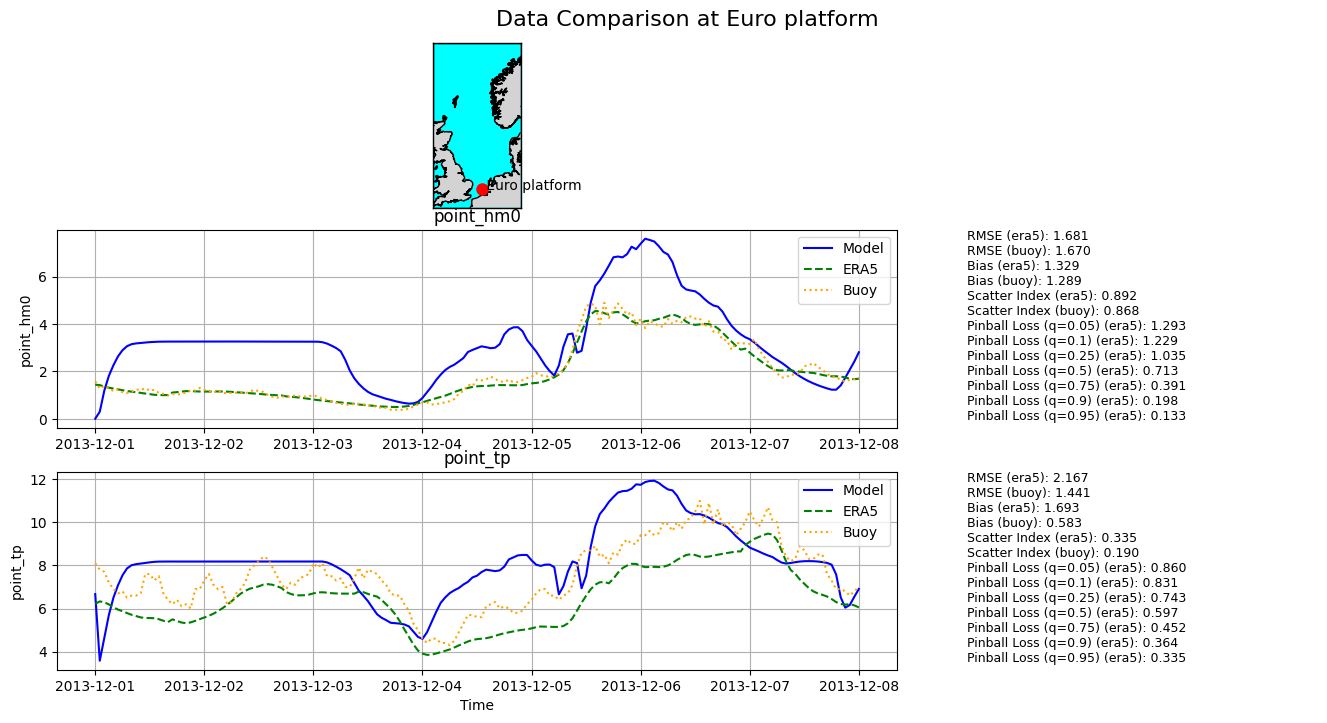

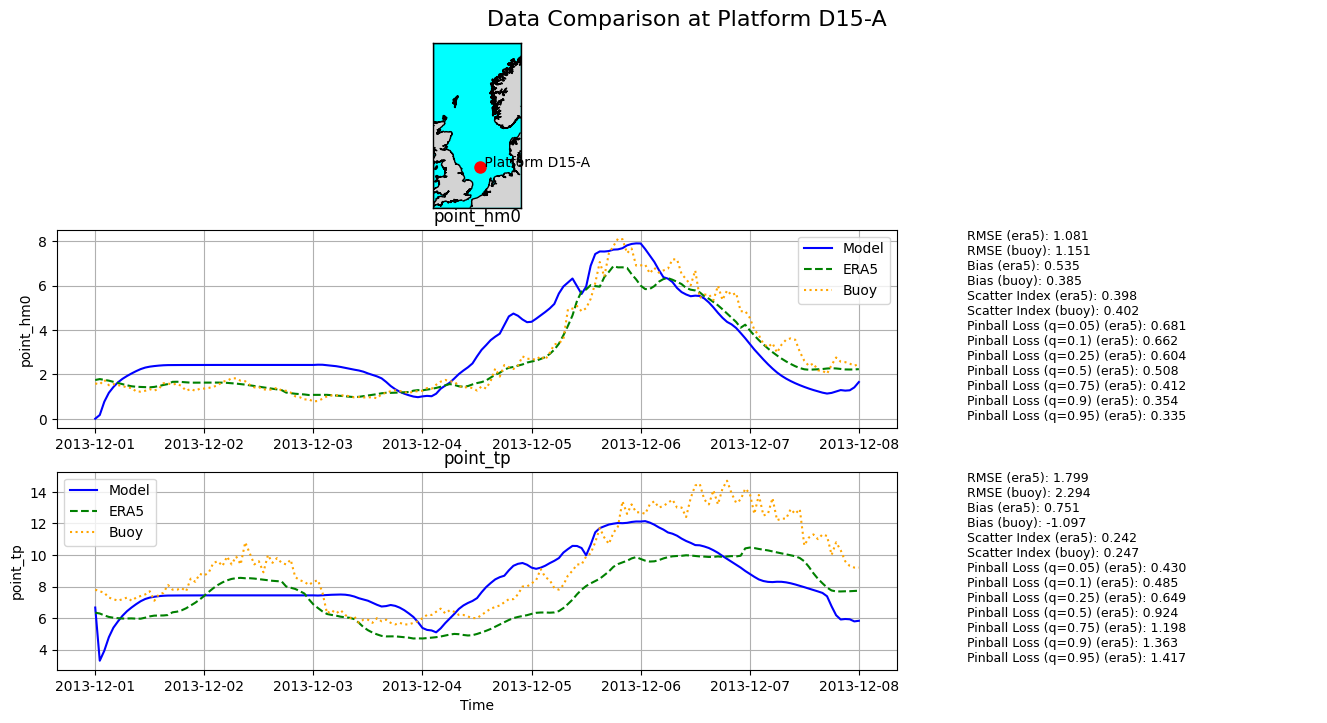

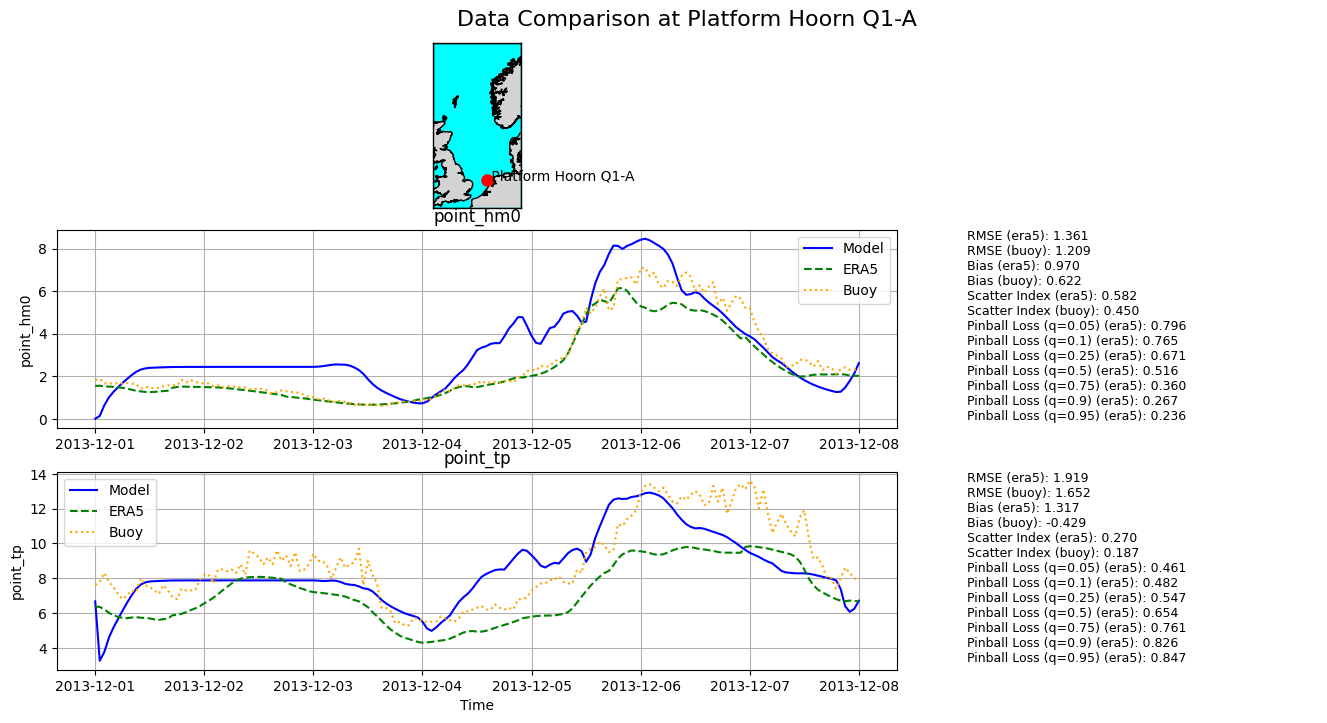

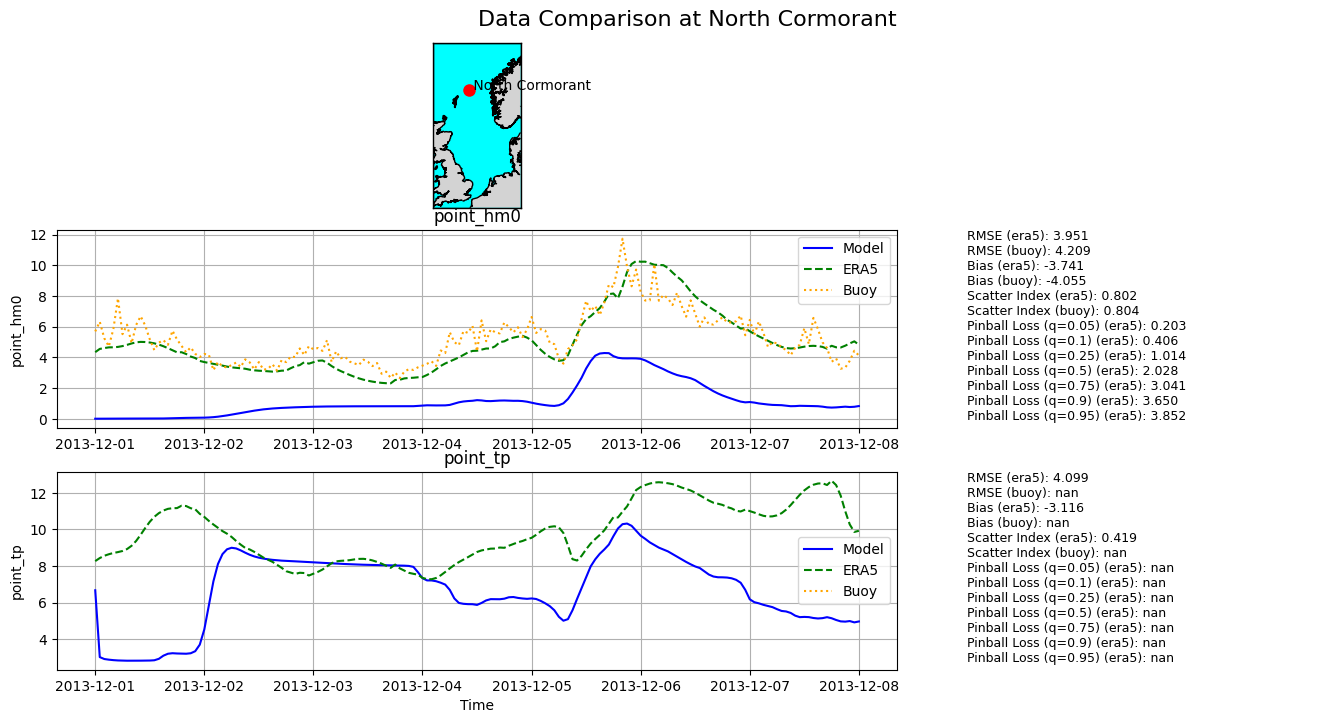

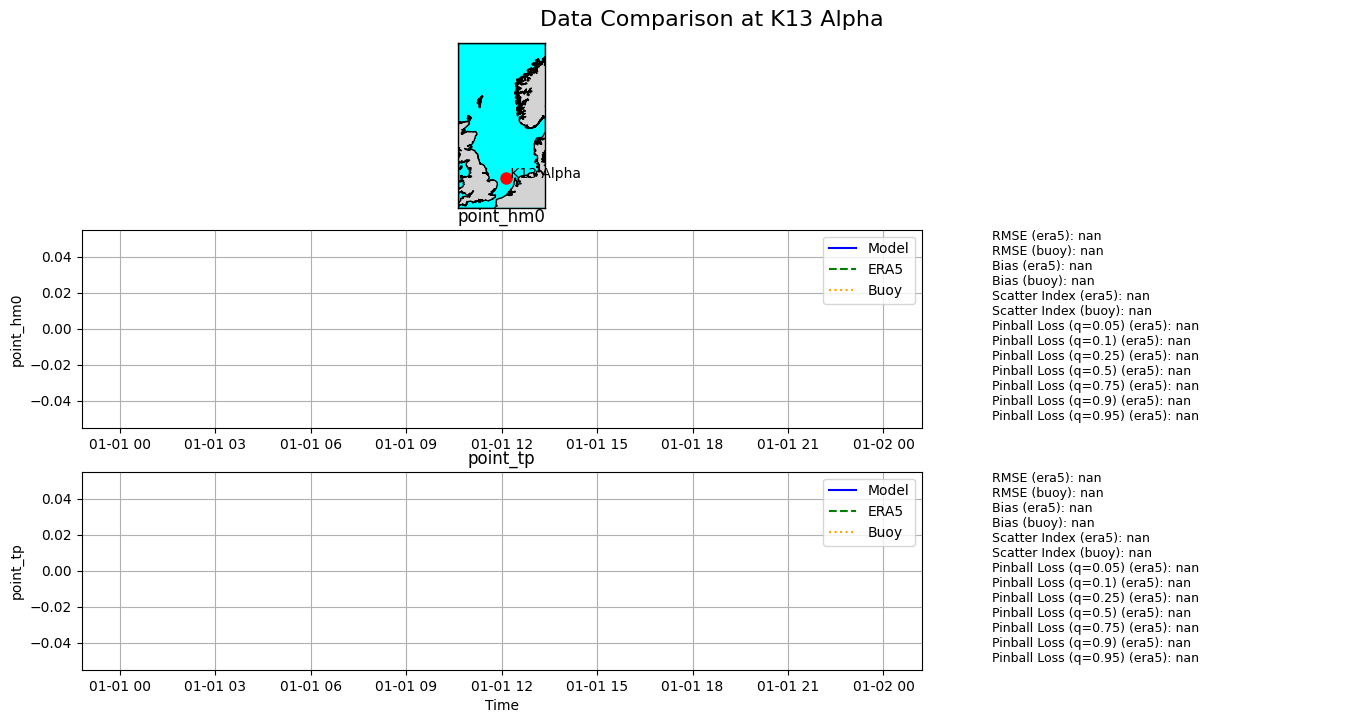

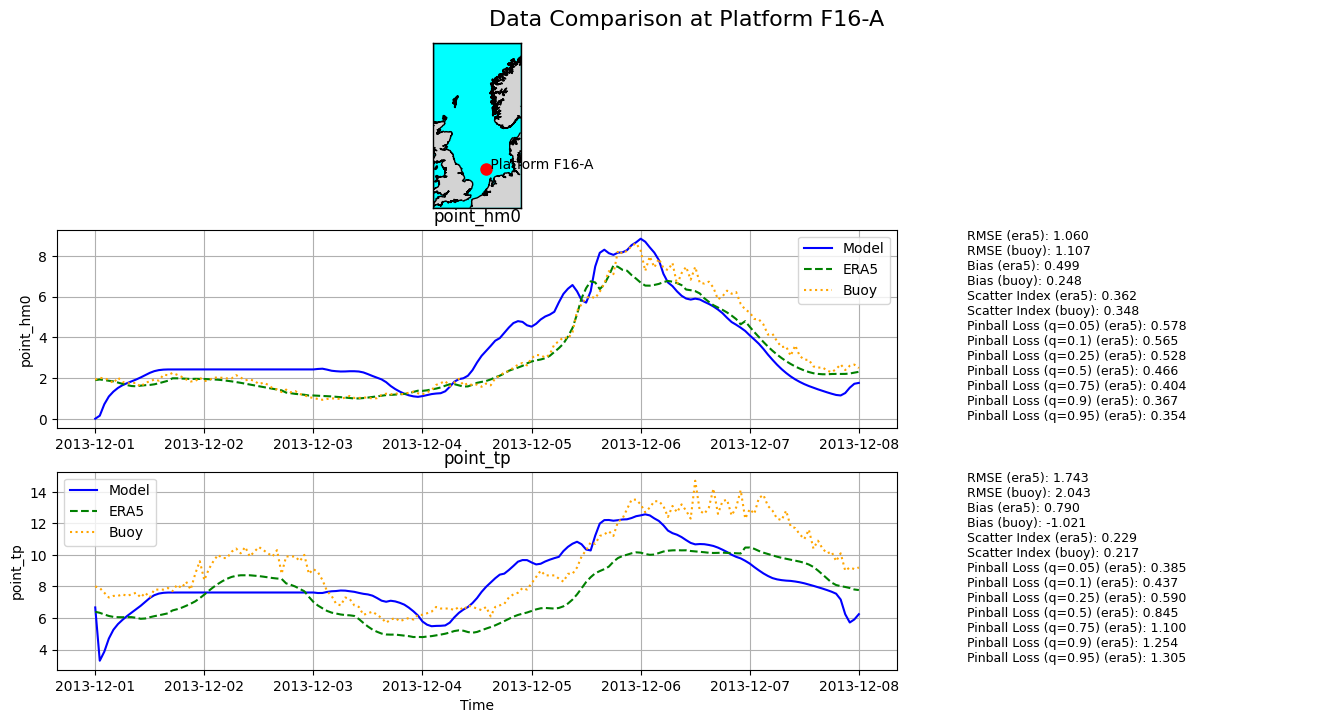

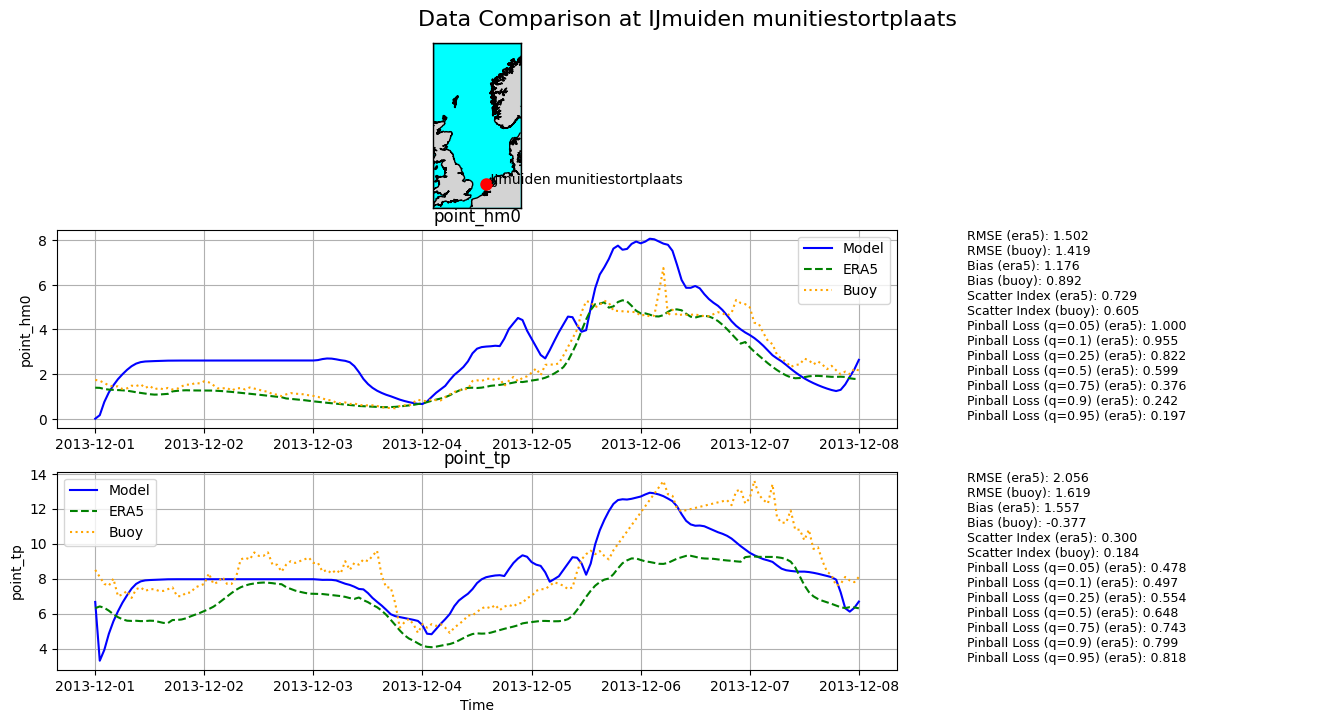

In [30]:
plot_all_stations(
    station_names = station_names,
    model_df=df_model,
    era5_df=df_era5,
    buoy_df=df_measurements,
    model_vars=variable_list,
    benchmarks=["era5", "buoy"],
    map_variable_era5 = variable_mapping_era5,
    map_variable_buoy = variable_mapping_measurements,
    df_statistics=df_statistics

)

# MAPS

In [31]:
bnd_path = os.path.join(model_path, 'hurrywave.bnd')
bnd = pd.read_csv(bnd_path, header=0, sep=' ', names=['x', 'y'])
bnd = np.array(bnd)

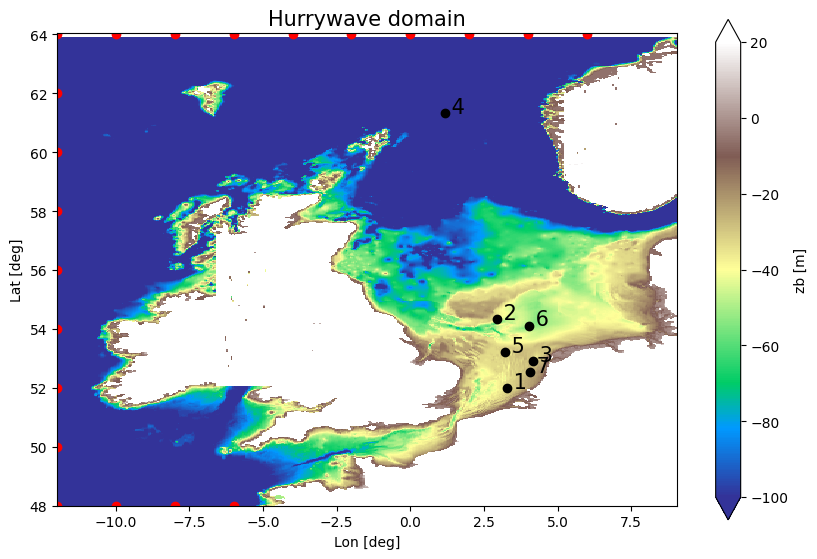

In [32]:
# plot bed level - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['zb'].plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "terrain",
                 vmin = -100, vmax = 20,
                 cbar_kwargs={'label': 'zb [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'bathy3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

We can plot other variables on this map, such as the maximum significant waveheight (Hm0_max)

Animation of the hurricane track (Check your output folder for the results!)

In [33]:
modig["Hm0"]

<xarray.DataArray 'hm0' (time: 337, n: 481, m: 421)> Size: 273MB
[68242837 values with dtype=float32]
Coordinates:
    x        (n, m) float32 810kB ...
    y        (n, m) float32 810kB ...
  * time     (time) datetime64[ns] 3kB 2013-12-01 ... 2013-12-08
Dimensions without coordinates: n, m
Attributes:
    units:          m
    standard_name:  sea_surface_wave_significant_height
    long_name:      Significant wave height Hm0 (m)

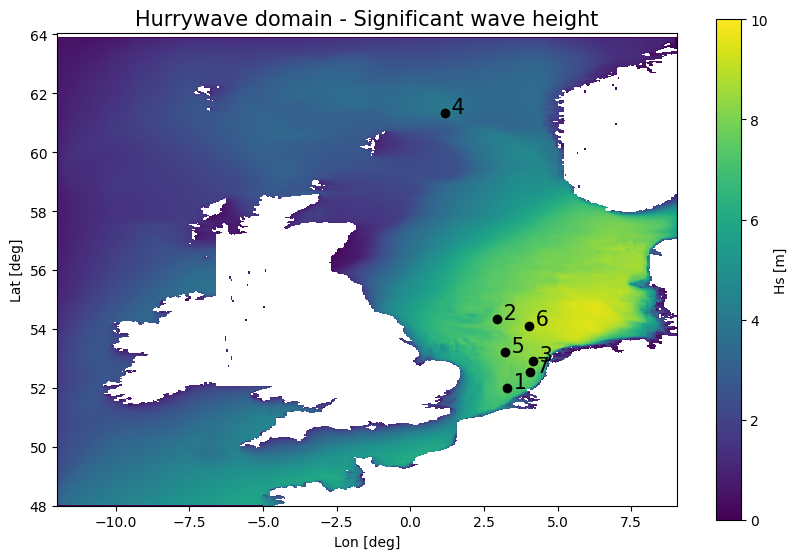

In [34]:
# plot wave height - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Hm0'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 0, vmax = 10,
                 cbar_kwargs={'label': 'Hs [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Significant wave height', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]') 

#plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveheight3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

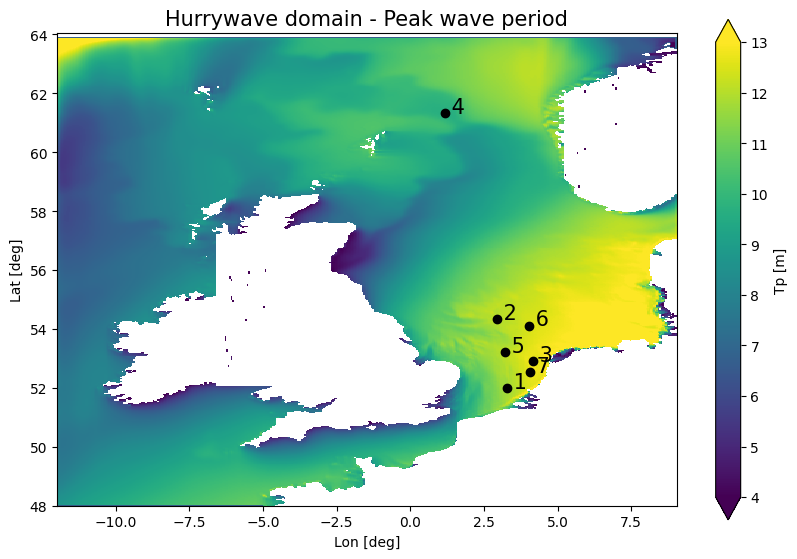

In [35]:
# plot wave period - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['Tp'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 vmin = 4, vmax = 13,
                 cbar_kwargs={'label': 'Tp [m]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Peak wave period', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'waveperiod3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

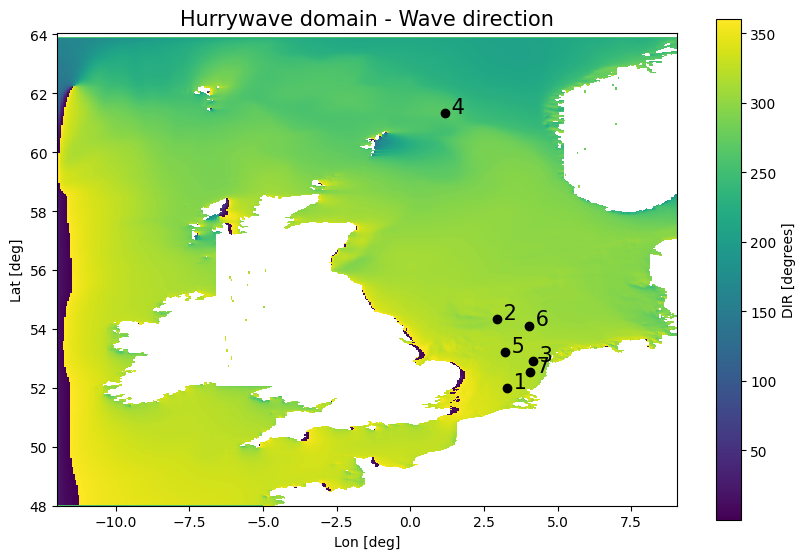

In [36]:
# plot wave direction - Hurrywave
fig, ax = plt.subplots(figsize=(10, 6.5), ncols=1, nrows=1, sharex=True, sharey=True)

im = modig['DIR'].isel(time=-97).plot(ax =ax,
                 x="x",
                 y="y",
                 cmap = "viridis",
                 cbar_kwargs={'label': 'DIR [degrees]'})

plt.scatter(his.station_x, his.station_y, color='k')
for x, y, id in zip(his.station_x.values, his.station_y.values, his.station_id.values):
    plt.text(x, y, ' ' + '{:.0f}'.format(id), color='k', fontsize=15)

ax.set_aspect('equal', adjustable='box')
ax.set_title('Hurrywave domain - Wave direction', fontsize = 15)

# ax.set_xticklabels([x for x in ax.get_xticks()])  # divide every tick value by 1000
# ax.set_yticklabels([y/1e3 for y in ax.get_yticks()])  # divide every tick value by 1000
ax.set_xlabel('Lon [deg]')
ax.set_ylabel('Lat [deg]')

# plt.scatter(bnd[:, 0], bnd[:, 1], color='red')
#xu_nc["zs"][1].ugrid.plot(ax=ax, cmap='gray')

output_path = os.path.join(output_dir, 'direction3.png')
fig.savefig(output_path, dpi=300, bbox_inches='tight')

In [37]:
modig

{'msk': <xarray.DataArray 'msk' (n: 481, m: 421)> Size: 810kB
 [202501 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
 Dimensions without coordinates: n, m
 Attributes:
     units:          -
     standard_name:  land_binary_mask
     long_name:      msk_active_cells
     description:    inactive=0, active=1, boundary=2,
 'zb': <xarray.DataArray 'zb' (n: 481, m: 421)> Size: 810kB
 [202501 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
 Dimensions without coordinates: n, m
 Attributes:
     units:          m
     standard_name:  altitude
     long_name:      bed_level_above_reference_level,
 'Hm0': <xarray.DataArray 'hm0' (time: 337, n: 481, m: 421)> Size: 273MB
 [68242837 values with dtype=float32]
 Coordinates:
     x        (n, m) float32 810kB ...
     y        (n, m) float32 810kB ...
   * time     (time) datetime64[ns] 3kB 2013-12-01 ... 2